Install relevant library

In [190]:
 #pip install scikit-learn numpy pandas matplotlib seaborn imblearn xgboost statsmodels

***Import Libraries***

In [191]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
import xgboost as xgb

#Metrics & Evaluation
from sklearn import tree
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Plotting Libs
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

***Define Model Metric Functions***

In [248]:
def get_feature_importance(model: object, features: list[str], model_name: str) -> dict[str, float]:
    #Feature Importance
    print('\n Feature Importances:')
    # Extract feature importances
    feature_importance = model.feature_importances_
    sorted_idx = model.feature_importances_.argsort()
    importances = model.feature_importances_[sorted_idx]  

    #Plot Feature Importance
    plt.barh(features[sorted_idx], importances)
    plt.xlabel(f'Feature Importance - {model_name}')
    #plt.savefig(f'Feature_importance-{model_name}.png', dpi = 500)
    return dict(zip(features[sorted_idx], importances))

def metrics_and_confusion_matrix( model:object, 
                                    X:pd.DataFrame, 
                                    Y:pd.DataFrame, 
                                    model_name:str,  
                                    type : str = 'Train',
                                    threshold: float = 0.5) -> None:
    #Score
    #y_pred = model.predict(X)
    pred_prob = model.predict_proba(X)
    y_pred = (pred_prob[:, 1] > threshold).astype(int)
    print(f"{type} Accuracy: {model.score(X, Y)}")
    print(classification_report(Y, y_pred))
    print(confusion_matrix(Y, y_pred))

def plot_tree(model: object, fn: list[str], cn: list[str], model_tpye:str) -> None:
       
    if model_tpye == 'decision_tree':
        plt.figure(figsize=(12,12))     # set plot size (denoted in inches)
        tree.plot_tree(model,fontsize=10,feature_names = fn,class_names=cn,filled = True)
        plt.show()
    elif model_tpye == 'random_forest':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,4), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(model.estimators_[index],feature_names = fn,class_names=cn,filled = True,ax = axes[index]);
            axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.show()
    elif model_tpye == 'xgb':
        image = xgb.to_graphviz(model)
        # fig, ax = plt.subplots(figsize=(30, 30))
        # xgb.plot_tree(model, num_trees=4, ax=ax)
        # plt.show()
        image.graph_attr = {'dpi':'400'}
        image.render('graph.png', format = 'png')

def roc_auc_curve(model: object, X:pd.DataFrame, Y:pd.DataFrame, model_name: str) -> None:
    # Plot ROC_AUC curve to further visualize TP rate vs FP rate
    y_score = model.predict_proba(X)

    n_classes = 2
    figsize=(16,10)
    fpr, tpr, roc_auc = dict(), dict(), dict()
 
    # calculate dummies once
    y_test_dummies = pd.get_dummies(Y, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    #pylab.savefig(f'DT_AUC_ROC_Curve-{model_name}.png')

***Data Loading & Previewing***

In [194]:
#Read the raw data
df=pd.read_csv(r"C:\git\python\projects\Machine-Learning\bank_affluent_classif\data\bank_customer_data.csv")
LABEL_COL = 'C_seg'
df.loc[df[LABEL_COL] == 'NORMAL', LABEL_COL] = 0
df.loc[df[LABEL_COL] == 'AFFLUENT', LABEL_COL] = 1

print('No of Datapoints --> ',len(df))
#Data Balance for Labels
print('The categories under +',df.groupby(LABEL_COL)[LABEL_COL].count())
print('\n\nThe % of categories are ', df.groupby(LABEL_COL)[LABEL_COL].count()/df[LABEL_COL].count()*100)

No of Datapoints -->  65689
The categories under + C_seg
0    55157
1    10532
Name: C_seg, dtype: int64


The % of categories are  C_seg
0    83.966874
1    16.033126
Name: C_seg, dtype: float64


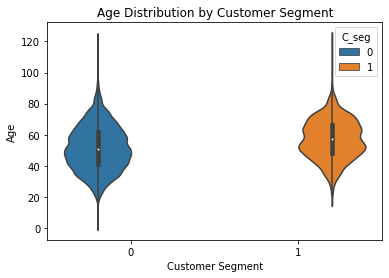

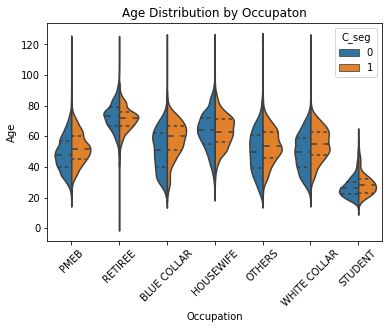

In [189]:
#Box Plot for Age vs C Seg
sns.violinplot(data=df, x="C_seg", y="C_AGE", hue="C_seg")
plt.xlabel('Customer Segment')
plt.ylabel('Age')
plt.title('Age Distribution by Customer Segment')
plt.show()

#Box Plot for Age vs C Seg per Occupaton
sns.violinplot(data=df, x="gn_occ", y="C_AGE", hue="C_seg", split=True,gap=0, inner="quart")
plt.xlabel('Occupation')
plt.xticks(rotation=45)
plt.ylabel('Age')
plt.title('Age Distribution by Occupaton')
plt.show()

#Box Plot for Age vs C Seg per Occupaton
# sns.violinplot(data=df, x="gn_occ", y="NUM_PRD", hue="C_seg", split=True,gap=0, inner="quart")
# plt.xlabel('Occupation')
# plt.xticks(rotation=45)
# plt.ylabel('Asset')
# plt.title('Asset Distribution vs Occupaton')
# plt.show()

In [195]:
# Quick Data Preview
print('################## Dataset Preview #########################')
df.head()

################## Dataset Preview #########################


,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,...,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,1443,65,Masters,EXECUTIVE CONDOMINIUM,19250.0,6.0,PMEB,3,8.0,6896.91,...,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,1
1,1559,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,...,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,1
2,1913,69,A-Levels,NaN,10155.0,3.0,PMEB,4,1.0,5420.09,...,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,1
3,2032,70,NaN,NaN,21863.0,2.0,RETIREE,3,1.0,13596.65,...,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
4,2048,72,O-Levels,EXECUTIVE CONDOMINIUM,10641.0,NaN,BLUE COLLAR,4,2.0,51639.18,...,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [196]:
#Summarize the data
print('################## Dataset Summary #########################')
df.describe()

################## Dataset Summary #########################


,C_ID,C_AGE,PC,INCM_TYP,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,...,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT
count,65689.000000,65689.000000,65211.000000,36503.000000,65689.000000,40989.000000,3.904300e+04,3.904300e+04,3.904300e+04,2.970700e+04,...,2.678000e+03,2.678000e+03,2678.000000,17072.000000,11733.000000,11733.000000,11733.000000,1.173300e+04,11733.000000,47499.000000
mean,41327.040692,52.338702,43233.056264,3.792044,2.103518,1.727854,1.614774e+04,1.544543e+04,1.317806e+04,3.662912e+04,...,4.562678e+04,5.207089e+04,1.447722,1433.526480,2812.945083,382.766932,848.137686,1.017765e+04,64.922952,5434.758984
std,27493.964736,14.325351,25674.656086,1.717919,1.093390,1.411323,6.683673e+04,6.505655e+04,5.443946e+04,1.329097e+05,...,5.447327e+04,6.140188e+04,0.920481,5017.021522,7971.455090,1028.178858,2690.348744,3.228418e+04,85.592620,13248.653573
min,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,-2.094051e+05,-2.094051e+05,-2.094051e+05,0.000000e+00,...,6.750000e-02,7.000000e-02,1.000000,0.000000,0.100000,0.040000,0.008333,1.000000e-01,1.000000,0.000000
25%,17386.000000,42.000000,21629.500000,2.000000,1.000000,1.000000,1.081410e+03,1.066800e+03,1.011905e+03,7.506331e+00,...,1.704585e+04,2.008031e+04,1.000000,16.196667,360.000000,26.820000,83.269167,9.992300e+02,8.000000,0.000000
50%,37650.000000,52.000000,41094.000000,4.000000,2.000000,1.000000,4.143700e+03,4.015310e+03,3.251040e+03,3.000000e+03,...,3.303736e+04,3.818595e+04,1.000000,126.095833,1193.390000,96.540000,327.046667,3.924560e+03,29.000000,0.000000
75%,62889.000000,63.000000,60774.500000,5.000000,3.000000,2.000000,1.362112e+04,1.301986e+04,1.088801e+04,3.000000e+04,...,5.767421e+04,6.547499e+04,2.000000,966.647083,3122.730000,366.000000,980.294167,1.176353e+04,88.000000,7000.000000
max,99996.000000,122.000000,99948.000000,8.000000,9.000000,39.000000,6.534839e+06,6.534839e+06,6.534839e+06,1.160000e+07,...,1.205991e+06,1.338365e+06,14.000000,201404.830000,296448.220000,24985.420000,129262.150800,1.551146e+06,1445.000000,380000.000000


In [197]:
#Dataset DTypes
df.dtypes

C_ID                 int64
C_AGE                int64
C_EDU               object
C_HSE               object
PC                 float64
INCM_TYP           float64
gn_occ              object
NUM_PRD              int64
CASATD_CNT         float64
MTHCASA            float64
MAXCASA            float64
MINCASA            float64
DRvCR              float64
MTHTD              float64
MAXTD              float64
Asset value        float64
HL_tag             float64
AL_tag             float64
pur_price_avg      float64
UT_AVE             float64
MAXUT              float64
N_FUNDS            float64
CC_AVE             float64
MAX_MTH_TRN_AMT    float64
MIN_MTH_TRN_AMT    float64
AVG_TRN_AMT        float64
ANN_TRN_AMT        float64
ANN_N_TRX          float64
CC_LMT             float64
C_seg               object
dtype: object

***Data Cleaning***

In [205]:
#Drop ID & PINCODE Columns
if 'C_ID' in df.columns or 'PC' in df.columns:
    df = df.drop(['C_ID', 'PC'],axis=1)

#Select Ages from 18 to 100
df = df[(df['C_AGE'] >= 18) & (df['C_AGE'] <= 100)]

# drop na values and change data type f the columns
for column_name, column_type in df.dtypes.iteritems():
    if column_type == 'object':
        df[column_name] = df[column_name].fillna('NA')
    elif column_type in ['int64', 'float64']:
        df[column_name] = df[column_name].fillna(0)

df_backup=df.copy()

#Convert categorical columns to number
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]
        
df.describe(include=[object,np.number]) # want to view only object and numerical data only

df['Has_CC'] = 1
#No CC Details , mean dont have credit card
df.loc[df['CC_AVE']+df['MAX_MTH_TRN_AMT']+df['MIN_MTH_TRN_AMT']+df['CC_LMT'] == 0, 'Has_CC'] = 0

**Basic Plotting**

In [206]:
df.columns

Index(['C_AGE', 'C_EDU', 'C_HSE', 'INCM_TYP', 'gn_occ', 'NUM_PRD',
       'CASATD_CNT', 'MTHCASA', 'MAXCASA', 'MINCASA', 'DRvCR', 'MTHTD',
       'MAXTD', 'Asset value', 'HL_tag', 'AL_tag', 'pur_price_avg', 'UT_AVE',
       'MAXUT', 'N_FUNDS', 'CC_AVE', 'MAX_MTH_TRN_AMT', 'MIN_MTH_TRN_AMT',
       'AVG_TRN_AMT', 'ANN_TRN_AMT', 'ANN_N_TRX', 'CC_LMT', 'C_seg', 'Has_CC'],
      dtype='object')

**HISTOGRAM PLOT**

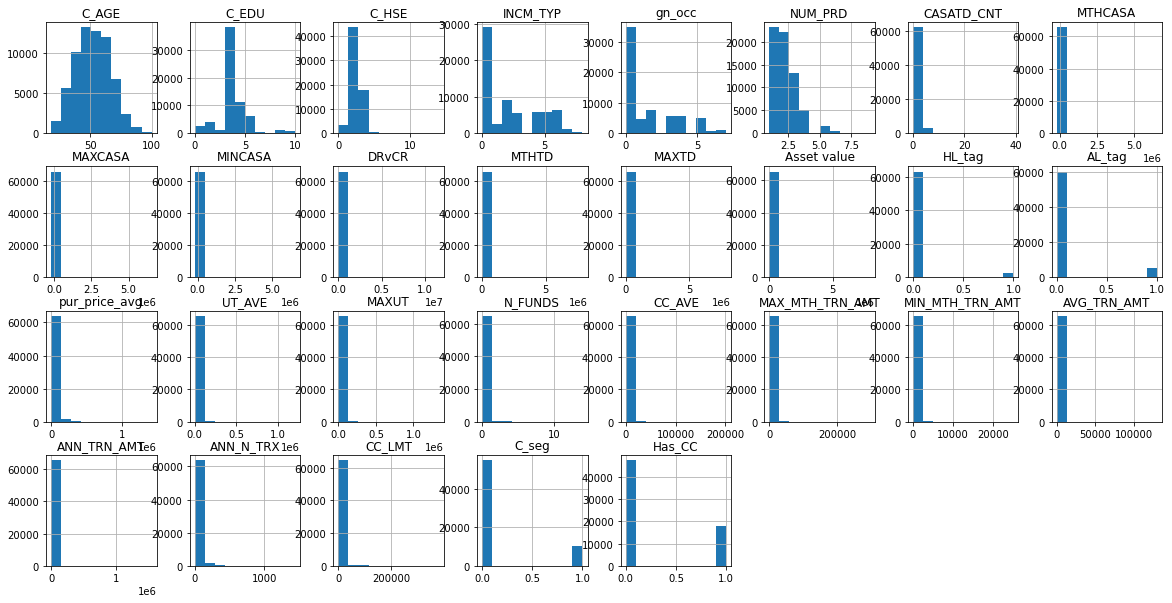

In [207]:
#Histogram Plots
p = df.hist(figsize = (20,10),bins=10,layout=(4,8))

**Q-Q Plot for Normalcy Test**

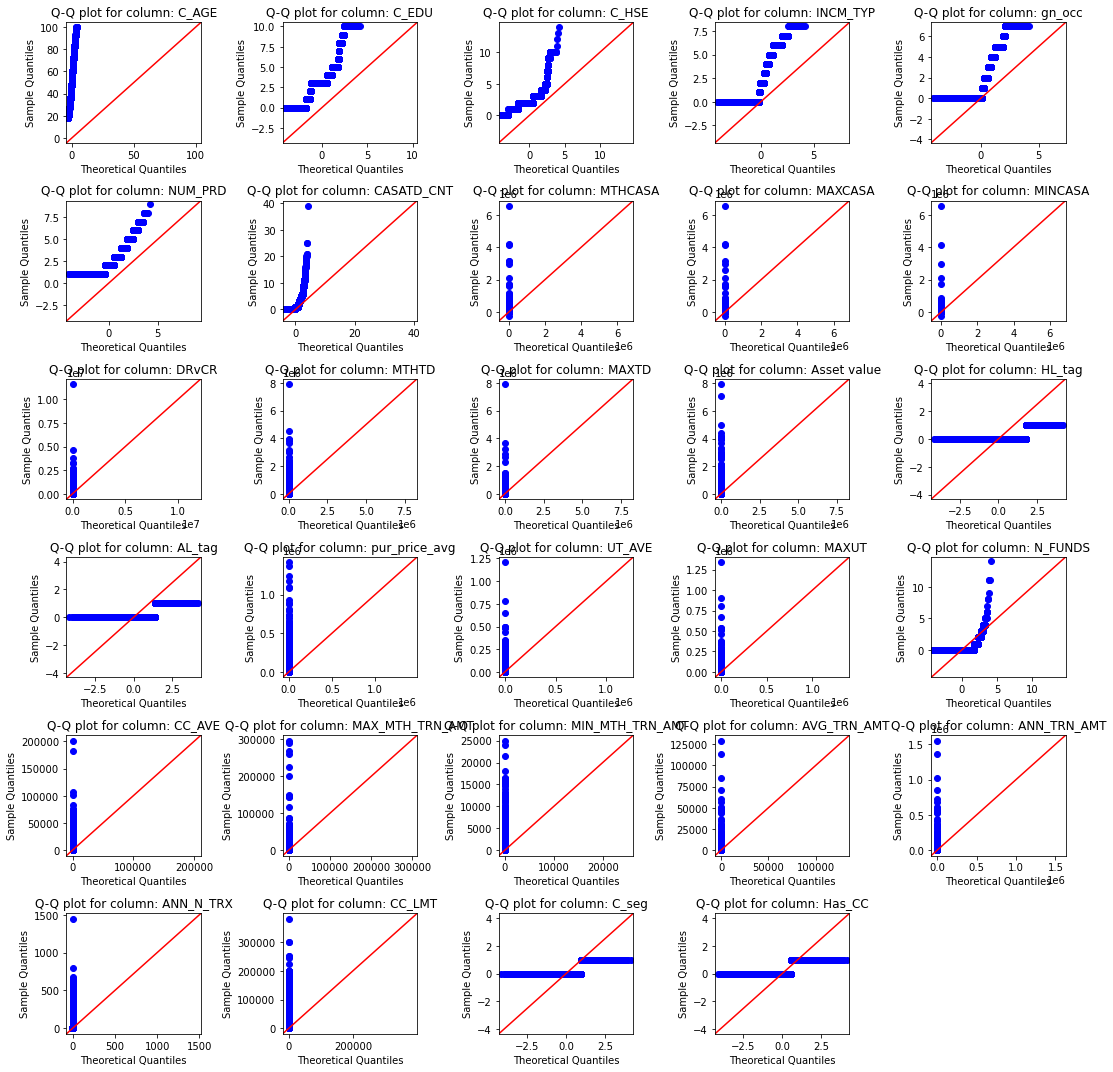

In [208]:
#Q-Q Plot for Normalcy

# Determine the number of columns in your dataframe
num_cols = len(df.columns)

# Define the number of rows and columns for your subplot grid
num_rows = int(np.ceil(num_cols / 5)) # Adjust the denominator to fit your preference
num_cols = 5 # Adjust this to your preference

# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,15))

# Remove extra subplots
for i in range(num_cols*num_rows - len(df.columns)):
    fig.delaxes(axs.flatten()[-(i+1)])

for ax, column in zip(axs.flatten(), df.columns):
    sm.qqplot(df[column].dropna(), ax=ax, line='45') #dropna to remove missing values
    ax.set_title(f"Q-Q plot for column: {column}")

# Display the figure with subplots
plt.tight_layout()
plt.show()

** Pearson Correlation** 
(No Spearman correlation as Q-Q Plots donot show Normal distribution)

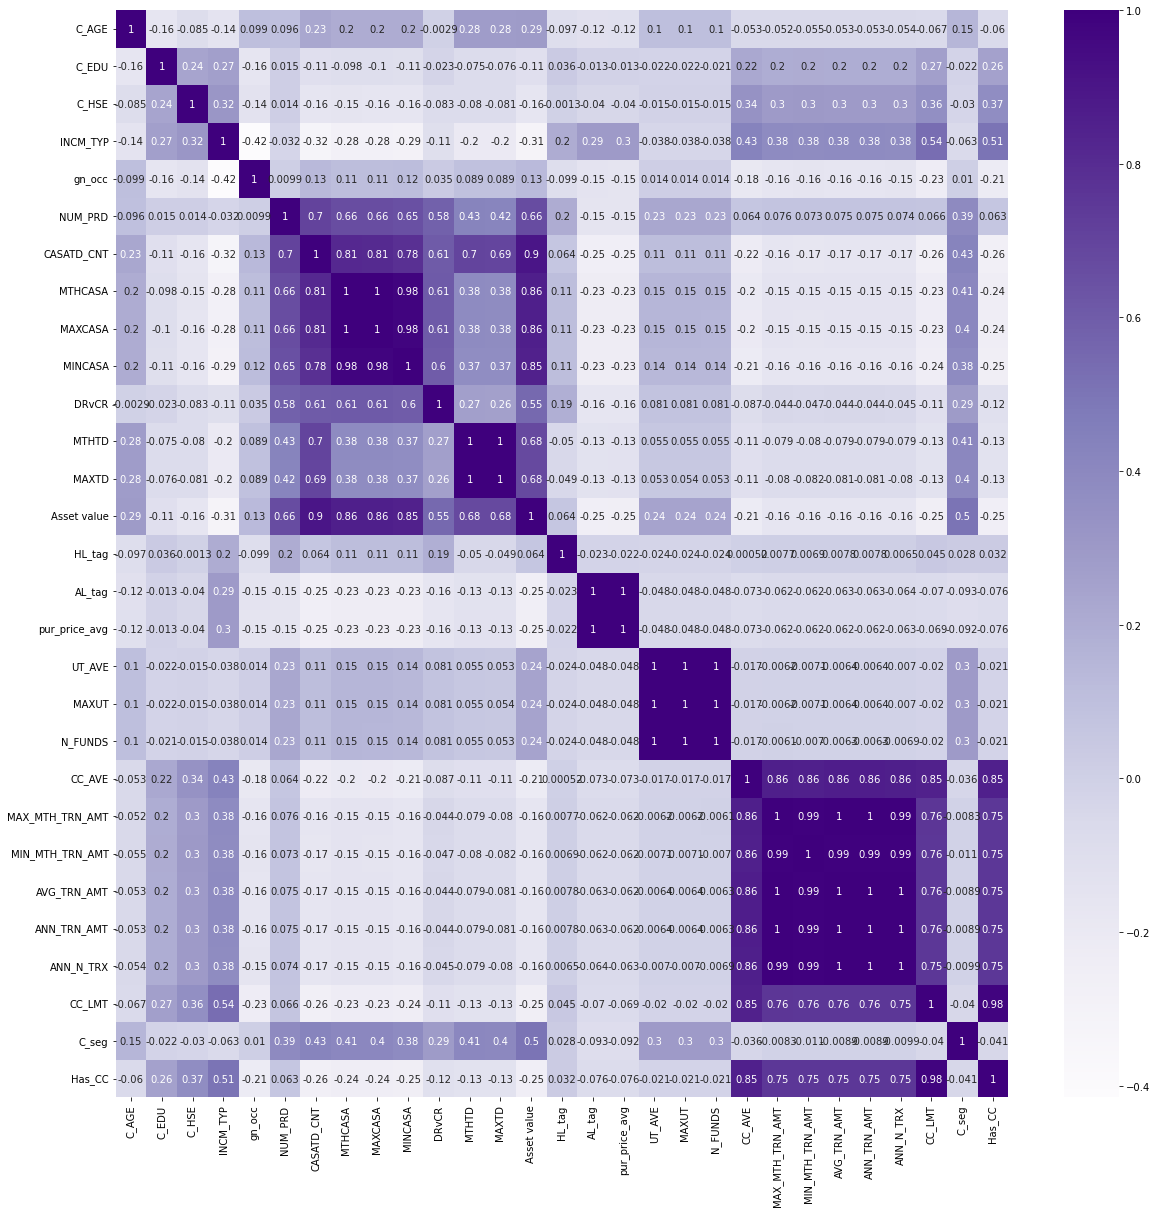

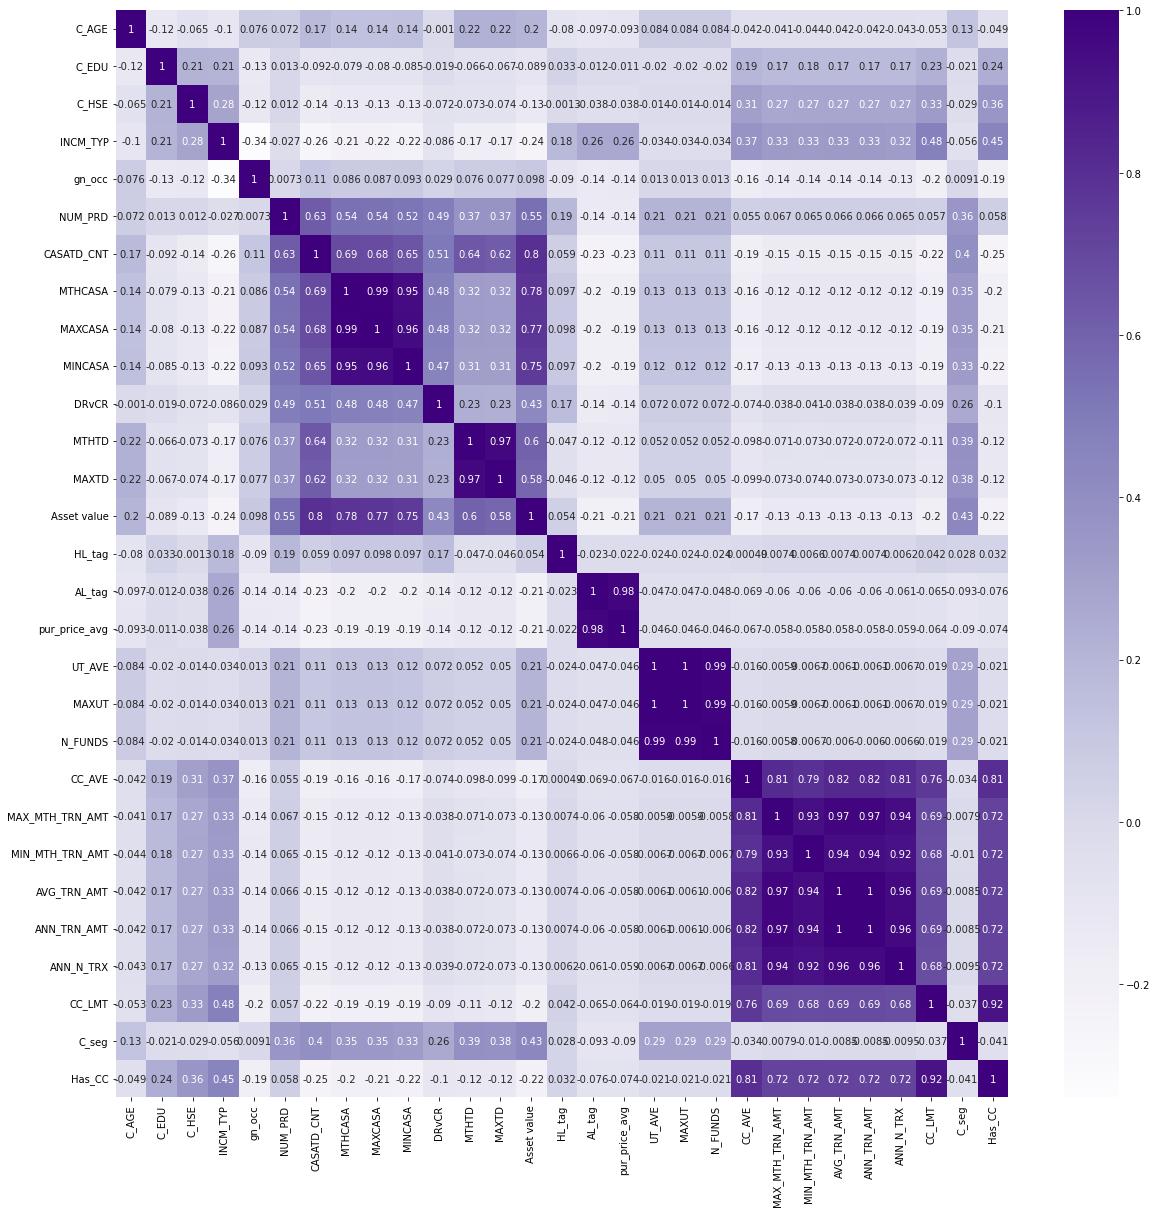

In [209]:
#Correlation Plots 
#fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
#pearson_corr = df.corr()
#sns.heatmap(pearson_corr,cmap="Purples",annot=True,ax=ax)
#X_train.corr()

# For Spearman correlation
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
spearman_corr = df.corr(method='spearman')
sns.heatmap(spearman_corr, cmap="Purples", annot=True)
plt.show()

# For Kendall's Tau
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
kendall_corr = df.corr(method='kendall')
sns.heatmap(kendall_corr, cmap="Purples", annot=True)
plt.show()


***Train Test Split***

In [210]:
#Assign Features & Labels
Xdata=df.drop([LABEL_COL],axis=1)
Ydata=df[LABEL_COL]

features = ['CASATD_CNT', 'CC_AVE', 
            'C_AGE', 'UT_AVE', 'NUM_PRD', 'DRvCR', 'Asset value']
#Xdata = Xdata[features]
#Split the data into training & testing 
X_train, X_test, y_train, y_test = train_test_split(Xdata,Ydata, test_size=0.2, random_state=0, stratify=Ydata)
print('Train ->', X_train.shape); print('Test ->', X_test.shape)

Train -> (52456, 28)
Test -> (13114, 28)


**MLFlow Tracking**

In [146]:
URL = 'http://192.168.79.44:5002'       #MLFlow tracking server URL
mlflow.set_tracking_uri(URL)            #Replace with your MLflow server URI

#Start Experiment
EXPERIMENT_NAME = "Maybank_Customer_Segmentation"
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    if experiment.lifecycle_stage == "deleted":
        mlflow.restores_experiment(experiment.experiment_id)
    EXPERIMENT_ID = experiment.experiment_id

In [166]:

def eval_metrics(actual: np.array, pred: np.array) -> dict[str, float]:
    accuracy = accuracy_score(actual, pred)
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    f1 = f1_score(actual, pred)
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    return {'accuracy':float(accuracy), 'precision':float(precision), 'recall':float(recall), 'f1':float(f1), 'tp':int(tp), 'tn':int(tn), 'fp':int(fp), 'fn':int(fn)}

def log_params_and_metrics_to_mlflow(model: object, X:pd.DataFrame, Y:pd.DataFrame, run_name:str, params: dict[str, object],prefix:str='train')-> None:
    #Log Metrics to MLFlow Tracking Server
    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=run_name):
        print(f'Started run -> {run_name}...')
        y_pred = model.predict(X_train)
        metrics_dict = eval_metrics(y_train, y_pred)
        print("Logging params and metrics...")
        # [Info] this is the segment where it is shown that how we manually log the parameters and metrics=======
        #Log Parameters only during training
        if prefix == 'train':
            for k,v in params.items():
                mlflow.log_param(k, v)
        for k,v in metrics_dict.items():
            mlflow.log_metric(f'{prefix} {k}', v)
        print('[Info] Saving model and artifacts...')
        mlflow.sklearn.log_model(model, "model")
        print('[Info] Done')
        run_id = mlflow.active_run().info.run_id
        print(run_id)

***Decision Tree Classifier (with MLFlow Integration)***

In [229]:
#Intialize the decision tree 
parameter_dict = {'random_state': 9, 'criterion': 'entropy', 'ccp_alpha': 0.005, 'class_weight': 'balanced'}
dt = DecisionTreeClassifier(**parameter_dict)  # change it to entropy
model_name = f'decisionTree_{dt.criterion}_ccp-{dt.ccp_alpha}'

#fit the model using training data
dt.fit(X_train.drop([],axis=1), y_train)

DecisionTreeClassifier(ccp_alpha=0.005, class_weight='balanced',
                       criterion='entropy', random_state=9)

Train Accuracy: 0.8204590513954553
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     44031
           1       0.47      0.84      0.60      8425

    accuracy                           0.82     52456
   macro avg       0.72      0.83      0.74     52456
weighted avg       0.88      0.82      0.84     52456

[[35949  8082]
 [ 1336  7089]]
Test Accuracy: 0.8151593716638706
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     11008
           1       0.46      0.83      0.59      2106

    accuracy                           0.82     13114
   macro avg       0.71      0.82      0.74     13114
weighted avg       0.88      0.82      0.83     13114

[[8944 2064]
 [ 360 1746]]

 Feature Importances:


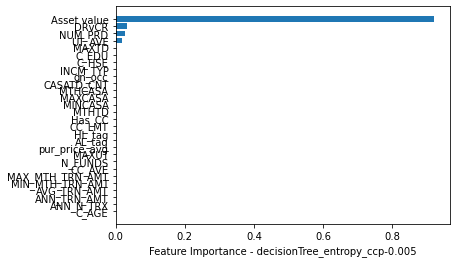

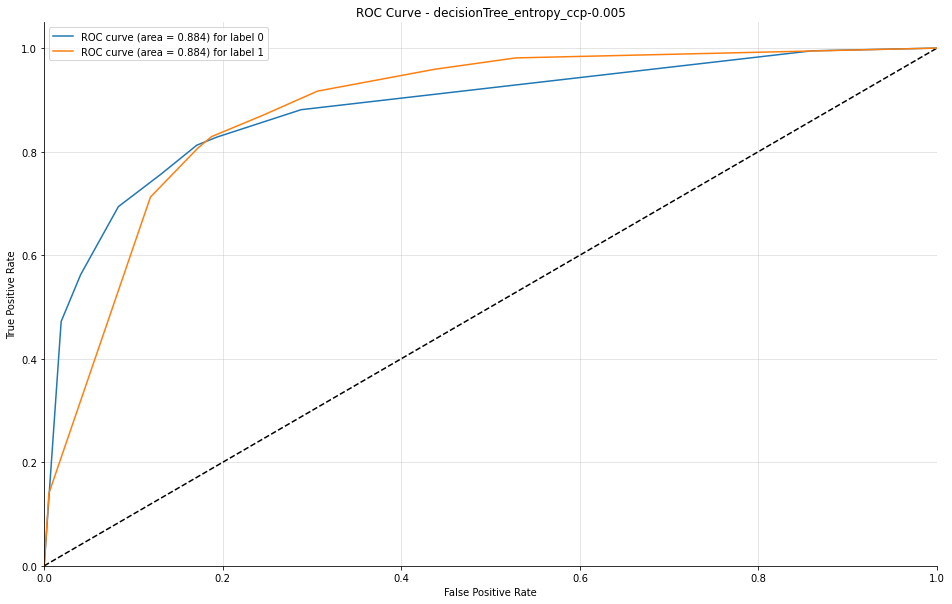

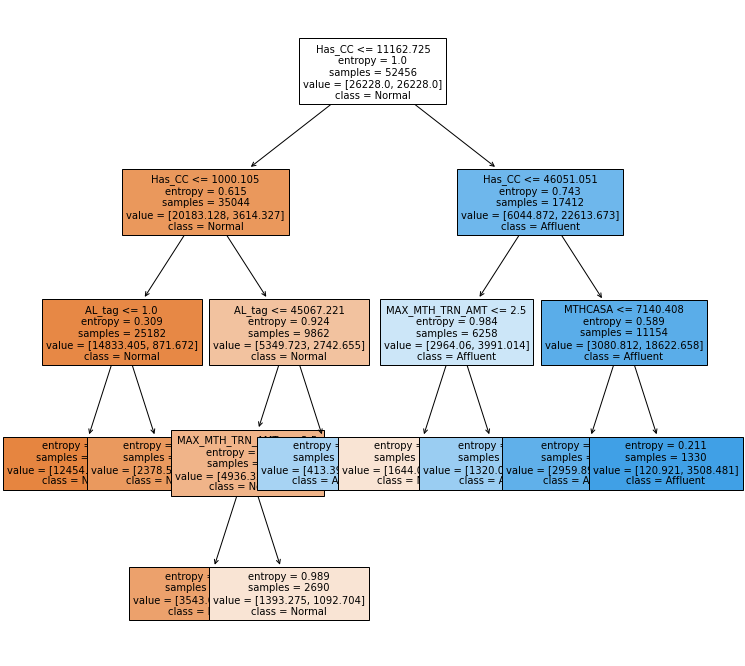

In [230]:
#Metrics
metrics_and_confusion_matrix(dt, X_train, y_train, model_name, 'Train')
metrics_and_confusion_matrix(dt, X_test, y_test, model_name, 'Test', threshold=0.5)
feature_imp = get_feature_importance(dt, X_train.columns,  model_name)
roc_auc_curve(dt, X_test, y_test, model_name)
plot_tree(dt, list(feature_imp.keys()), ['Normal','Affluent'], 'decision_tree')

In [170]:
#MLFlow Logging
#log_params_and_metrics_to_mlflow(dt,X_train, y_train, model_name, parameter_dict, 'train')
#log_params_and_metrics_to_mlflow(dt,X_test, y_test, model_name, parameter_dict, 'test')

***RandomForest Classifier***

In [234]:
#Init Random Forest Model 
model_name = f'RandomForest'
rf = RandomForestClassifier(n_estimators=300,
                            criterion= 'gini',
                            ccp_alpha = 0.001,
                            random_state = 1337,)

#Fit the random Forest with training data
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, n_estimators=300, random_state=1337)

Train Accuracy: 0.876982614000305
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     44031
           1       0.69      0.42      0.52      8425

    accuracy                           0.88     52456
   macro avg       0.79      0.69      0.73     52456
weighted avg       0.86      0.88      0.86     52456

[[42451  1580]
 [ 4873  3552]]
Test Accuracy: 0.8776879670581058
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     11008
           1       0.85      0.12      0.21      2106

    accuracy                           0.86     13114
   macro avg       0.86      0.56      0.57     13114
weighted avg       0.86      0.86      0.81     13114

[[10964    44]
 [ 1848   258]]

 Feature Importances:


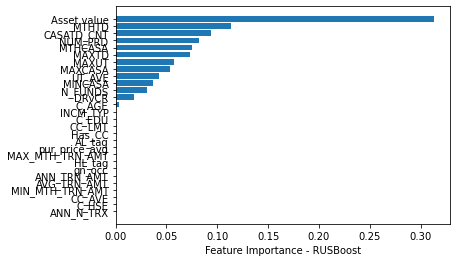

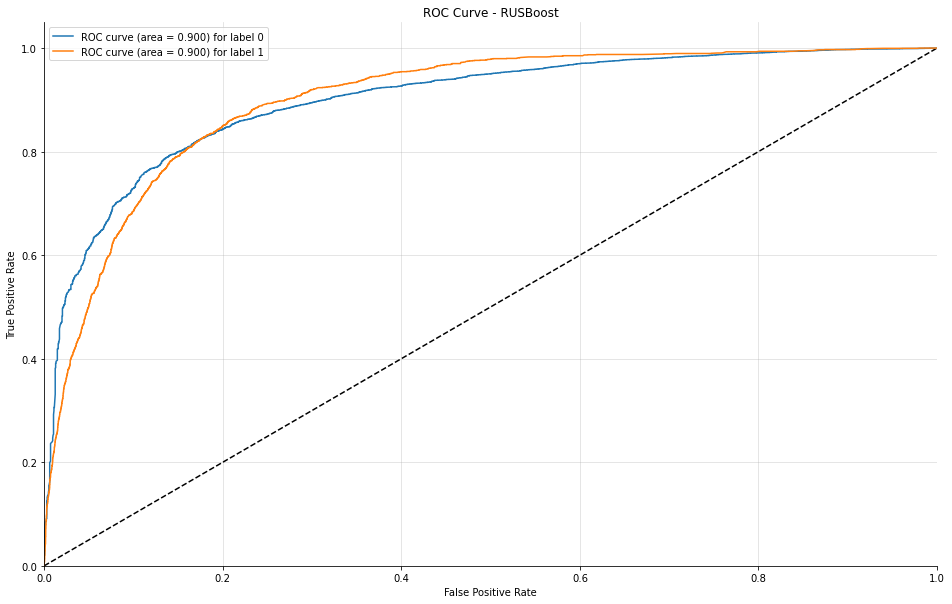

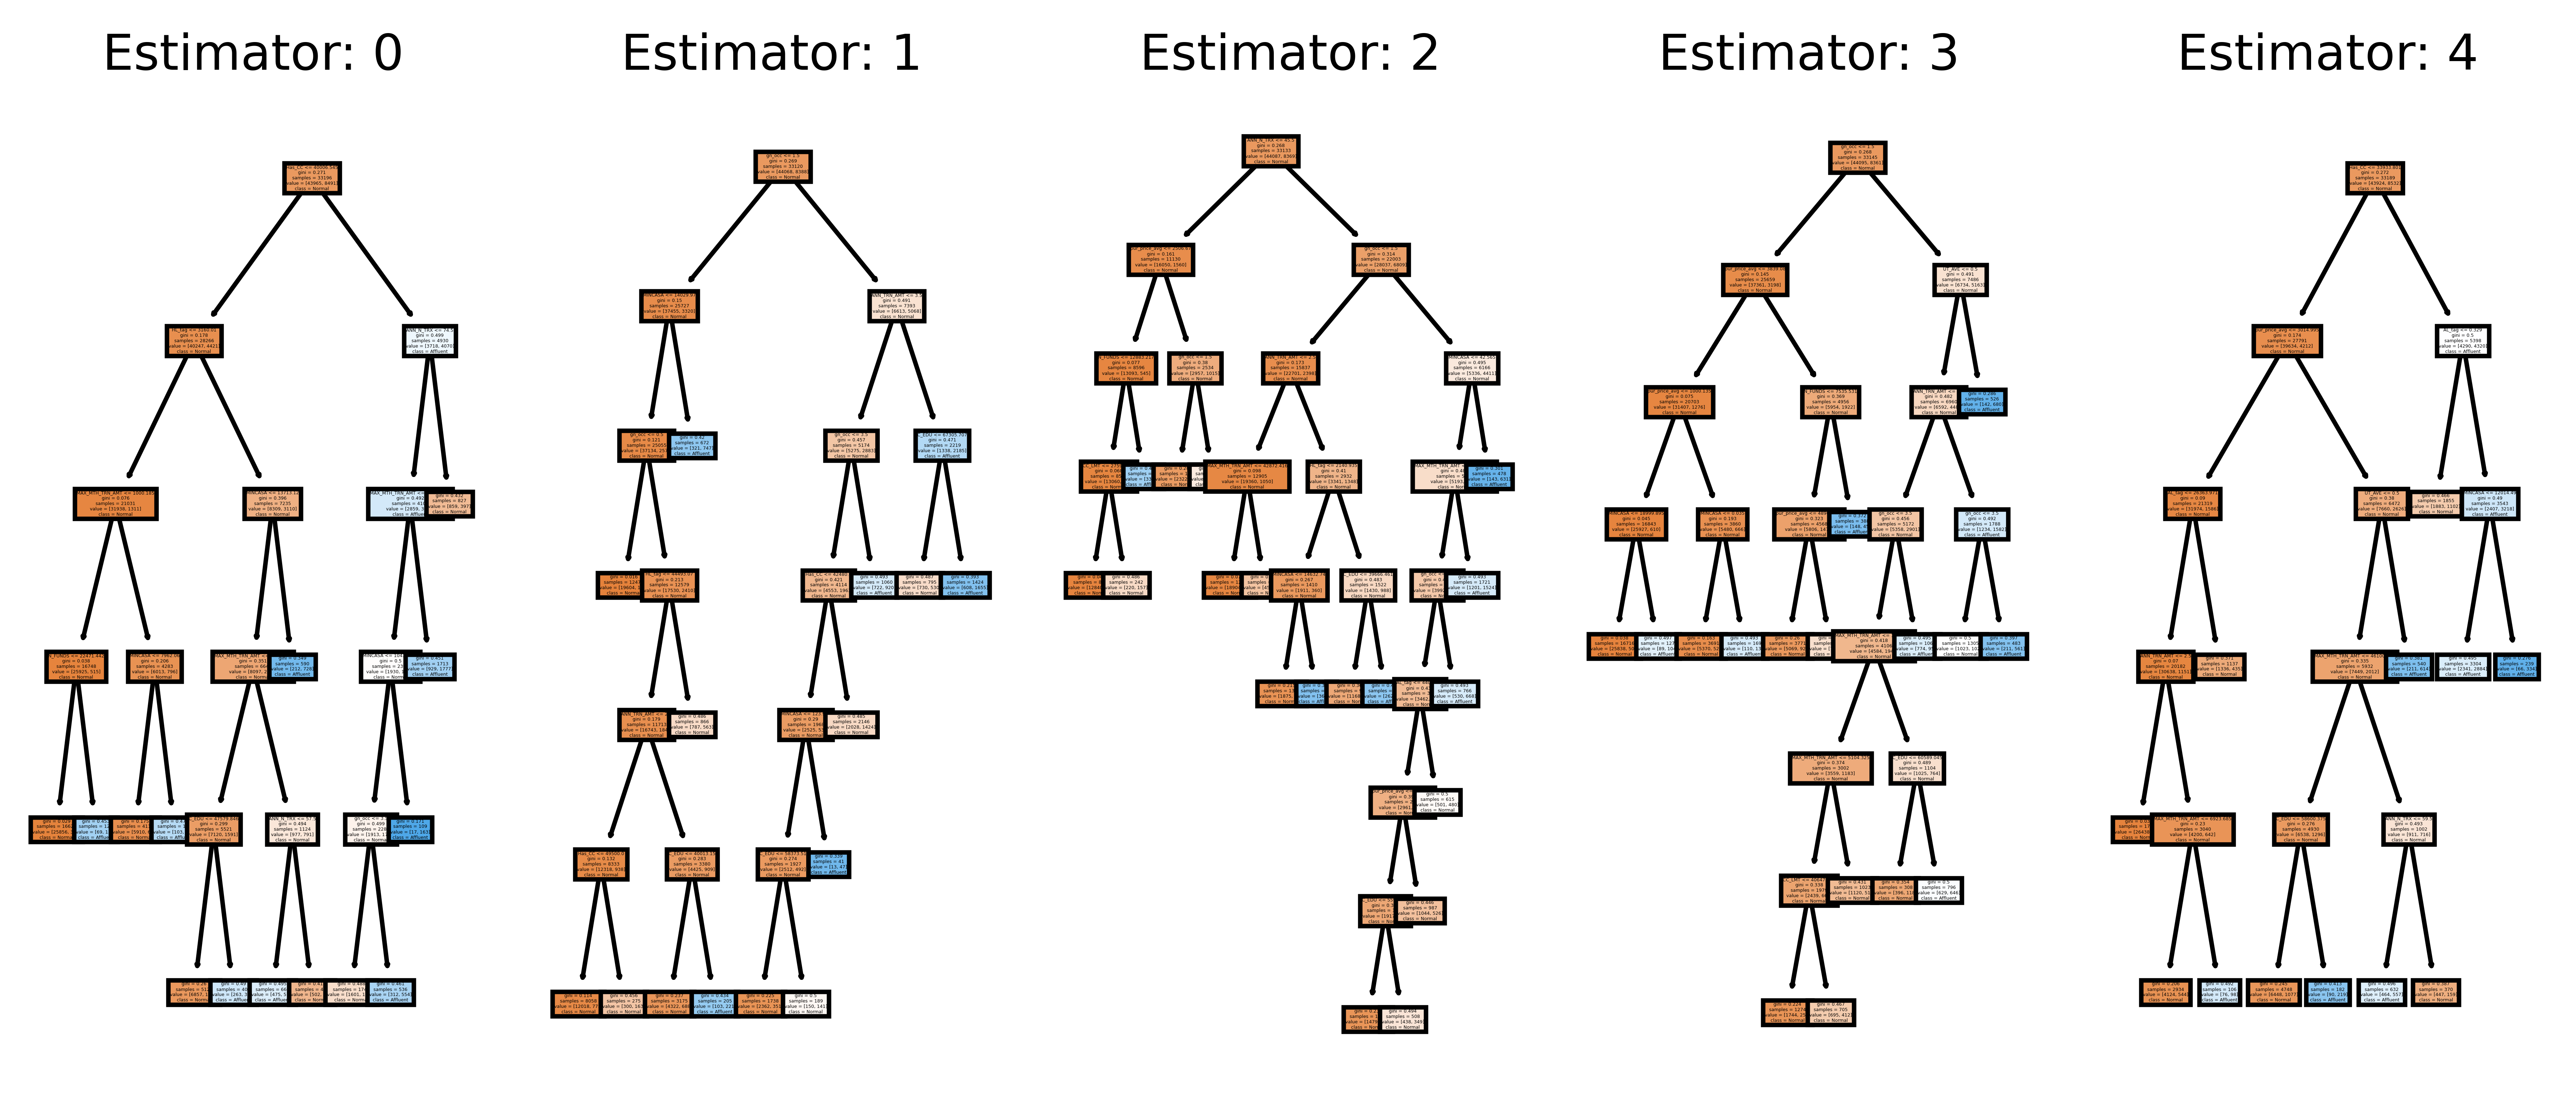

In [249]:
#Metrics
metrics_and_confusion_matrix(rf, X_train, y_train, model_name, 'Train')
metrics_and_confusion_matrix(rf, X_test, y_test, model_name, 'Test', threshold = 0.7)
feature_importnace = get_feature_importance(rf, X_train.columns,  model_name)
roc_auc_curve(rf, X_test, y_test, model_name)
plot_tree(rf, list(feature_importnace.keys()), ['Normal','Affluent'], 'random_forest')

***xGBoost Classifier***

In [242]:
#Init xGBoost classifier
model_name = f'xGBoost'
xgb_model = xgb.XGBClassifier(n_estimators=300,
                            learning_rate=0.01,
                            max_depth = 10,
                            seed = 1337,
                            objective = 'reg:squarederror')
#Fit the random Forest with training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.075, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, objective='reg:squarederror',
              predictor='auto', random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1337, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Train Accuracy: 0.9725865487265518
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     44031
           1       0.99      0.84      0.91      8425

    accuracy                           0.97     52456
   macro avg       0.98      0.92      0.95     52456
weighted avg       0.97      0.97      0.97     52456

[[43954    77]
 [ 1361  7064]]
Test Accuracy: 0.879136800366021
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     11008
           1       0.65      0.53      0.58      2106

    accuracy                           0.88     13114
   macro avg       0.78      0.74      0.76     13114
weighted avg       0.87      0.88      0.87     13114

[[10421   587]
 [  998  1108]]

 Feature Importances:


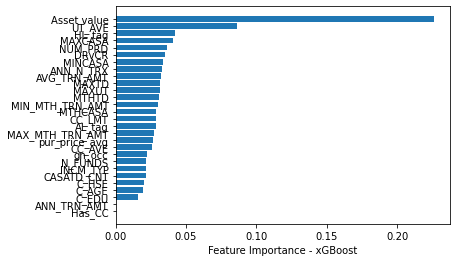

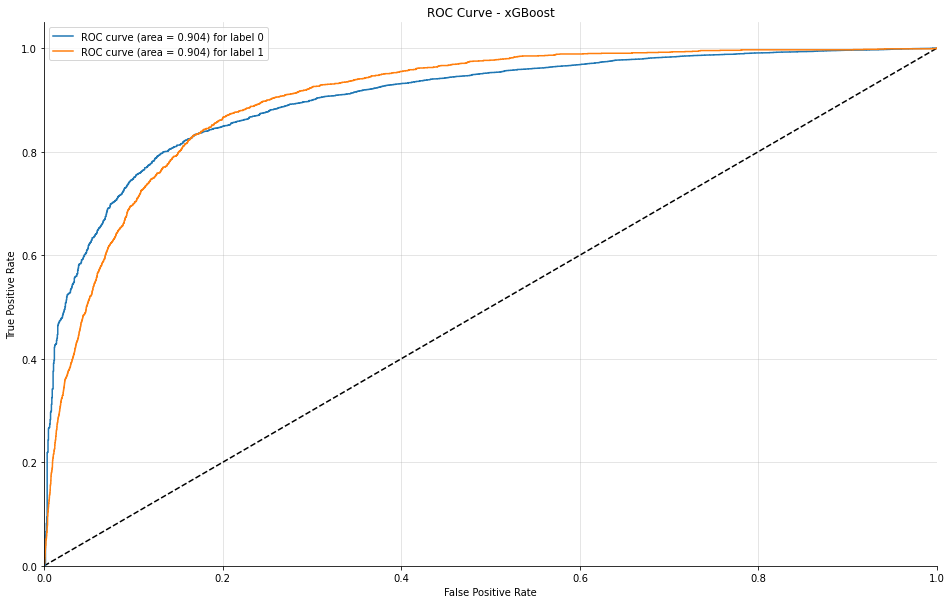

In [243]:
#Metrics
metrics_and_confusion_matrix(xgb_model, X_train, y_train, model_name, 'Train')
metrics_and_confusion_matrix(xgb_model, X_test, y_test, model_name, 'Test')
feature_importnace = get_feature_importance(xgb_model, X_train.columns,  model_name)
roc_auc_curve(xgb_model, X_test, y_test, model_name)

***RUSBoost Classifier***

In [244]:
#Initialize the RUSBOOST classifier
model_name = f'RUSBoost'
rusboost = RUSBoostClassifier(n_estimators=100, 
                                learning_rate= 1, 
                                random_state=7, 
                                sampling_strategy ='auto')
"""
    'majority': resample only the majority class;
    'not minority': resample all classes but the minority class;
    'not majority': resample all classes but the majority class;
    'all': resample all classes;
    'auto': equivalent to 'not minority'.
"""

#Fit the random Forest with training data
rusboost.fit(X_train, y_train)

RUSBoostClassifier(learning_rate=1, n_estimators=100, random_state=7)

Train Accuracy: 0.8231688829211244
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     38527
           1       0.48      0.81      0.60      7647

    accuracy                           0.82     46174
   macro avg       0.72      0.82      0.74     46174
weighted avg       0.88      0.82      0.84     46174

[[31837  6690]
 [ 1475  6172]]
Test Accuracy: 0.824548991864167
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     16512
           1       0.48      0.81      0.61      3277

    accuracy                           0.82     19789
   macro avg       0.72      0.82      0.75     19789
weighted avg       0.88      0.82      0.84     19789

[[13651  2861]
 [  611  2666]]

 Feature Importances:


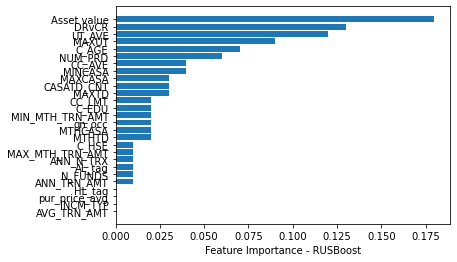

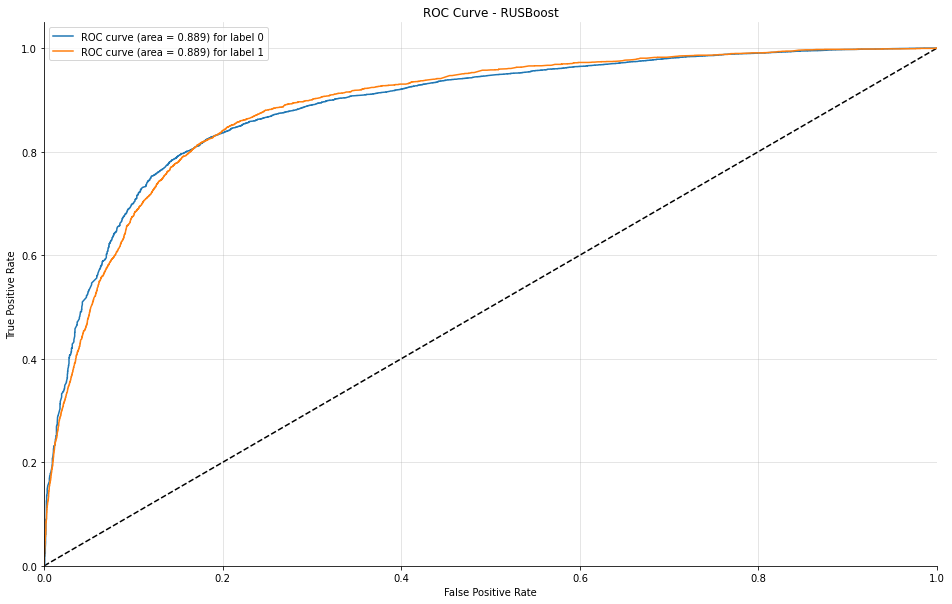

<Figure size 432x288 with 0 Axes>

In [93]:
#Metrics
metrics_and_confusion_matrix(rusboost, X_train, y_train, model_name, 'Train')
metrics_and_confusion_matrix(rusboost, X_test, y_test, model_name, 'Test')
feature_importnace = get_feature_importance(rusboost, X_train.columns,  model_name)
roc_auc_curve(rusboost, X_test, y_test, model_name)